In [6]:
import numpy as np

# true params
m_true = -0.9594
b_true = 4.294
f_true = 0.534

#generate data (linear)
N = 50
x = np.sort(10*np.random.rand(N))
yerr = 0.1+0.5*np.random.rand(N)
y = m_true*x+b_true
y += np.abs(f_true*y) * np.random.randn(N)
y += yerr * np.random.randn(N)

In [12]:
import matplotlib.pyplot as plt

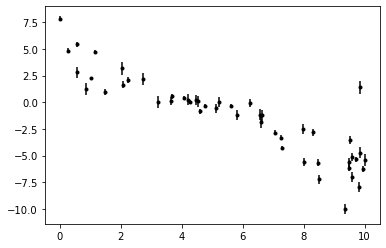

In [18]:
plt.errorbar(x, y, xerr=None, yerr = yerr,fmt='.k')
plt.show()

In [21]:
A = np.vstack((np.ones_like(x), x)).T
C = np.diag(yerr * yerr)
cov = np.linalg.inv(np.dot(A.T, np.linalg.solve(C, A)))
b_ls, m_ls = np.dot(cov, np.dot(A.T, np.linalg.solve(C, y)))

In [22]:
def lnlike(theta, x, y, yerr):
    m, b, lnf = theta
    model = m * x + b
    inv_sigma2 = 1.0/(yerr**2 + model**2*np.exp(2*lnf))
    return -0.5*(np.sum((y-model)**2*inv_sigma2 - np.log(inv_sigma2)))

In [23]:
import scipy.optimize as op
nll = lambda *args: -lnlike(*args)
result = op.minimize(nll, [m_true, b_true, np.log(f_true)], args=(x, y, yerr))
m_ml, b_ml, lnf_ml = result["x"]


In [24]:
def lnprior(theta):
    m, b, lnf = theta
    if -5.0 < m < 0.5 and 0.0 < b < 10.0 and -10.0 < lnf < 1.0:
        return 0.0
    return -np.inf


In [25]:
def lnprob(theta, x, y, yerr):
    lp = lnprior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + lnlike(theta, x, y, yerr)

In [26]:
ndim, nwalkers = 3, 100
pos = [result["x"] + 1e-4*np.random.randn(ndim) for i in range(nwalkers)]

In [32]:

import emcee
sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob, args=(x, y, yerr))
sampler.run_mcmc(pos, 500, progress=True)


100%|████████████████████████████████████████| 500/500 [00:01<00:00, 439.20it/s]


State([[-0.93073839  3.96083207 -0.85757665]
 [-1.05476248  4.51198965 -0.83256354]
 [-1.01840321  4.37418054 -0.71837801]
 [-1.13533581  4.87933759 -0.53680135]
 [-1.08826763  4.57034061 -0.74119439]
 [-0.98894348  4.28842738 -0.8218463 ]
 [-0.97399961  4.2072403  -0.58700867]
 [-0.91742456  3.96394236 -0.686156  ]
 [-1.0578633   4.4085054  -0.92434223]
 [-0.92072088  3.97292253 -0.73055682]
 [-0.85137328  3.60886388 -0.75725784]
 [-0.89676907  3.79094816 -0.69776961]
 [-0.98259448  4.15369675 -0.54151395]
 [-0.99363316  4.33843815 -0.85551572]
 [-1.04783871  4.53916509 -0.51110854]
 [-0.81782756  3.54459234 -0.74726151]
 [-1.02519865  4.47294988 -0.8145888 ]
 [-0.86596612  3.76231644 -0.58799907]
 [-0.96538922  4.18790367 -0.71897323]
 [-0.99904236  4.4812347  -0.68168111]
 [-0.9721726   4.18625245 -0.64146434]
 [-0.97070515  4.11118301 -0.75636169]
 [-1.02523832  4.38858973 -0.77934544]
 [-1.05704062  4.61722393 -1.18267157]
 [-0.9001243   3.88381322 -0.63860227]
 [-0.86160215  3.62

In [45]:
true_params=[m_true,b_true,f_true]

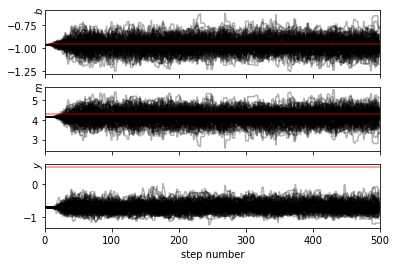

In [64]:
#samples = sampler.chain[:, 50:, :].reshape((-1, ndim))
samples = sampler.get_chain()
fig, axes =plt.subplots(3,sharex=True)
labels=("$b$","$m$","$y$")
for i in range(ndim):
    ax=axes[i]
    ax.plot(samples[:,:, i],"k", alpha=0.3)
    ax.axhline(y=true_params[i],color='r',alpha=0.5)
    ax.set_xlim(0,len(samples))
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(0,1)
axes[-1].set_xlabel("step number");

/home/user/anaconda3/envs/compact-binaries/lib/python3.8/site-packages/arviz/data/base.py:220: UserWarning: More chains (500) than draws (100). Passed array should have shape (chains, draws, *shape)
  warnings.warn(


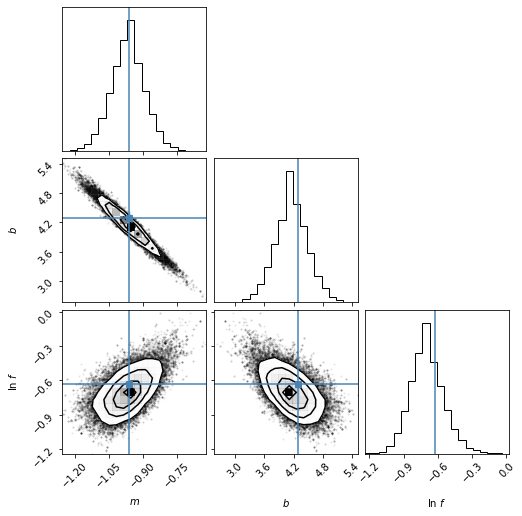

In [65]:
import corner
fig = corner.corner(samples, labels=["$m$", "$b$", "$\ln\,f$"],
                      truths=[m_true, b_true, np.log(f_true)])
fig.savefig("triangle.png")
